## **Exploratory Analysis** <a id="EDA"></a>
Our data exploration starts by checking that each entry is unique and there are no duplicates;
this is done by veryfing that the number of unique ProductID corresponds to the number of
observations. Then we print a report to look for missing values and check the data type for each
column.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("/kaggle/input/predictive-maintenance/predictive_maintenance.csv")
n = data.shape[0]
data.info()
print('Check for duplicate values:',
      data['Product ID'].unique().shape[0]!=n)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
Check for duplicate values: False


To make this distinction more clear we set numeric columns to float type.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

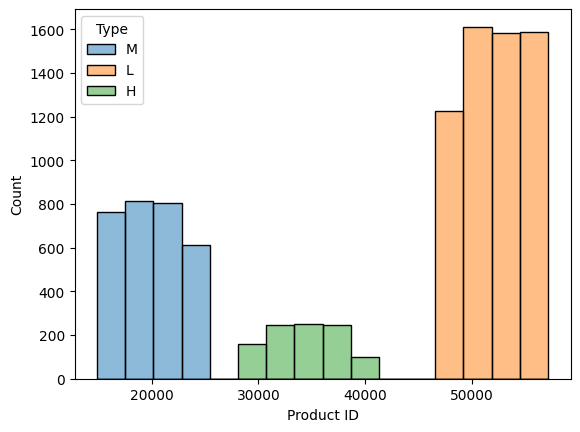

In [30]:
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')

data.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)

data['Product ID'] = data['Product ID'].apply(lambda x: x[1:])
data['Product ID'] = pd.to_numeric(data['Product ID'])

sns.histplot(data=data, x='Product ID', hue='Type')
plt.show()

In [31]:
# Drop ID columns
df = data.copy()
df.drop(columns=['UDI','Product ID'], inplace=True)

The following pie chart shows the percentages of machines by Type:

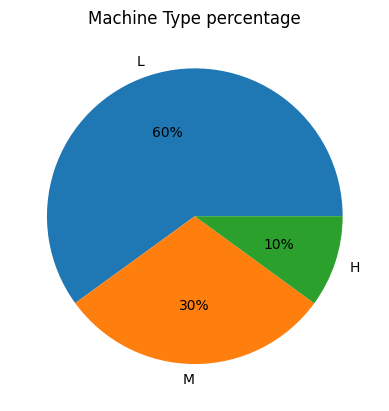

In [32]:
value = data['Type'].value_counts()
Type_percentage = 100*value/data.Type.shape[0]
labels = Type_percentage.index.array
x = Type_percentage.array
plt.pie(x, labels = labels, colors=sns.color_palette('tab10')[0:3], autopct='%.0f%%')
plt.title('Machine Type percentage')
plt.show()

### Target anomalies <a id="target"></a>

In this section we observe the distribution of the target to find any imbalances and correct them
before dividing the dataset.
The first anomaly respect to dataset’s description is that when the failure is random (RNF), the
Machine Failure feature is not set to 1.

In [33]:
features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']

idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index
df.loc[idx_RNF,target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


In [34]:
first_drop = df.loc[idx_RNF,target].shape[0]
print('Number of observations where RNF=1 but Machine failure=0:',first_drop)
df.drop(index=idx_RNF, inplace=True)

Number of observations where RNF=1 but Machine failure=0: 18


Going forward we find out that in 9 observations Machine failure is set to 1 when all types
of failures are set to 0. We cannot understand if there really was a failure or not so let’s remove
these observations too.

In [35]:
idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
second_drop = df.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations:', second_drop)
display(df.loc[idx_ambiguous,target])
df.drop(index=idx_ambiguous, inplace=True)

Number of ambiguous observations: 9


,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


In [36]:
print('Global percentage of removed observations:',
     (100*(first_drop+second_drop)/n))
df.reset_index(drop=True, inplace=True)
n = df.shape[0]

Global percentage of removed observations: 0.27


### Outliers inspection <a id="outliers"></a>

The goal of this section is to check if the dataset contains any outlier, which are usually misleading
for machine learning algorithms. We begin by looking at a statistical report of the numerical
features.

In [37]:
df.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,300.003259,310.004031,1538.893212,39.978993,107.921087,0.033089
std,2.000548,1.483692,179.412171,9.966805,63.649152,0.178879
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.700000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


We can guess the presence of outliers in Rotational Speed and Torque because the maximum is
very different from the third quartile. To make this consideration more concrete we take a closer
look at the situation with boxplots, using histograms to understand the distribution.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

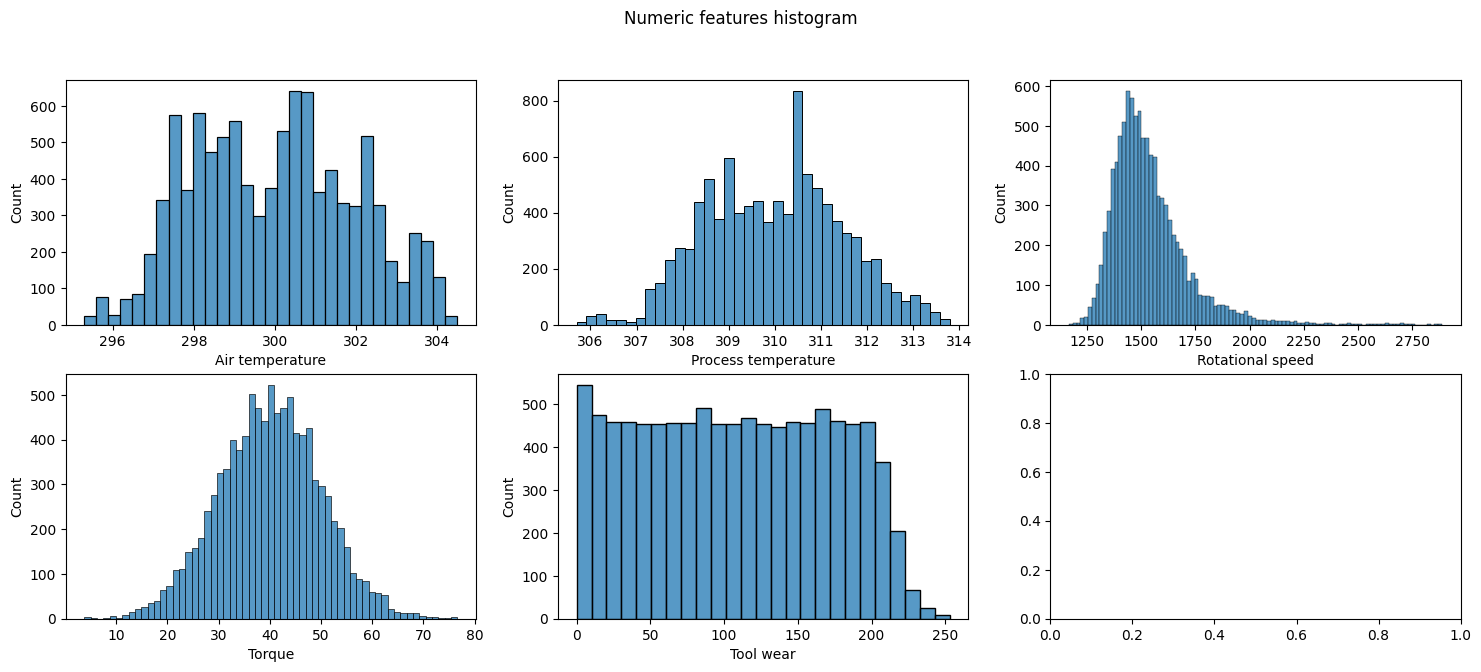

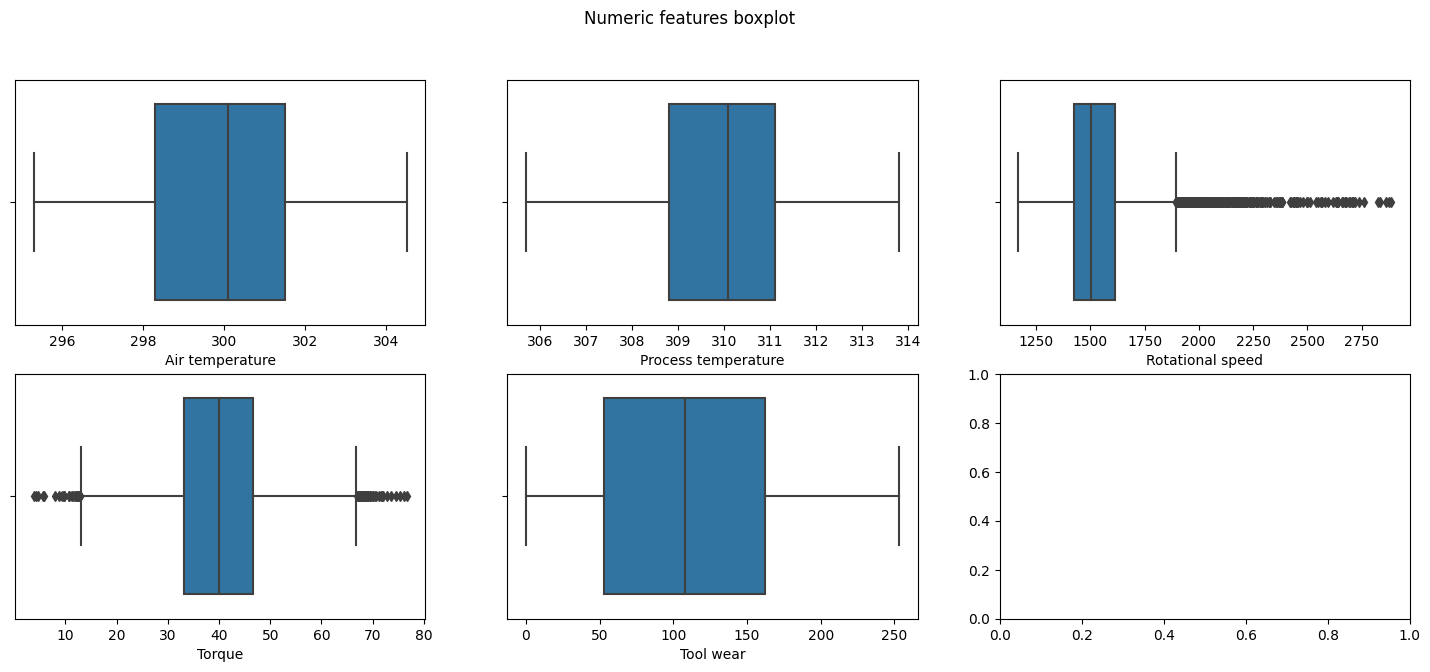

In [38]:
num_features = [feature for feature in features if df[feature].dtype=='float64']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features histogram')
for j, feature in enumerate(num_features):
    sns.histplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

Another important consideration regards the extremely low occurrence of machine failures among
the entire dataset, which percentage is equal only to 3.31%. Moreover, a pie plot showing the
occurrence of the causes involved for each failure reveals a further degree of imbalance.

Failures percentage in data: 3.31


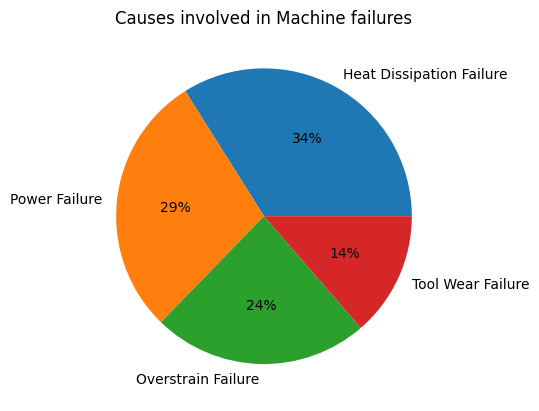

In [39]:
idx_fail = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
print('Failures percentage in data:',
      round(100*df['Target'].sum()/n,2))

plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

In [40]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4) 

balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

### Comparison after resampling <a id="resample_comparison"></a>

The result is described in the following pie charts.

Percentage increment of observations after oversampling: 20.88
SMOTE Resampled Failures percentage: 20.01


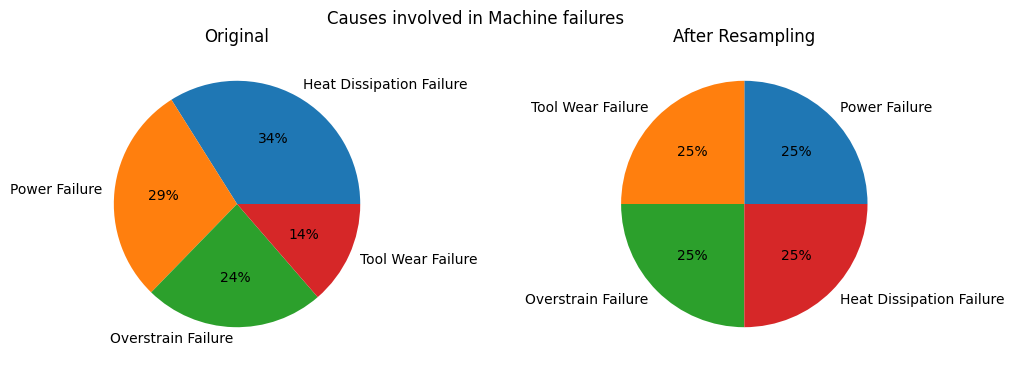

In [41]:
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

print('Percentage increment of observations after oversampling:',
      round((df_res.shape[0]-df.shape[0])*100/df.shape[0],2))
print('SMOTE Resampled Failures percentage:',
      round(df_res_fail.shape[0]*100/df_res.shape[0],2))

fig, axs = plt.subplots(ncols=2, figsize=(12,4))
fig.suptitle('Causes involved in Machine failures')
axs[0].pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[1].pie(x=fail_res_percentage.array, labels=fail_res_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[0].title.set_text('Original')
axs[1].title.set_text('After Resampling')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

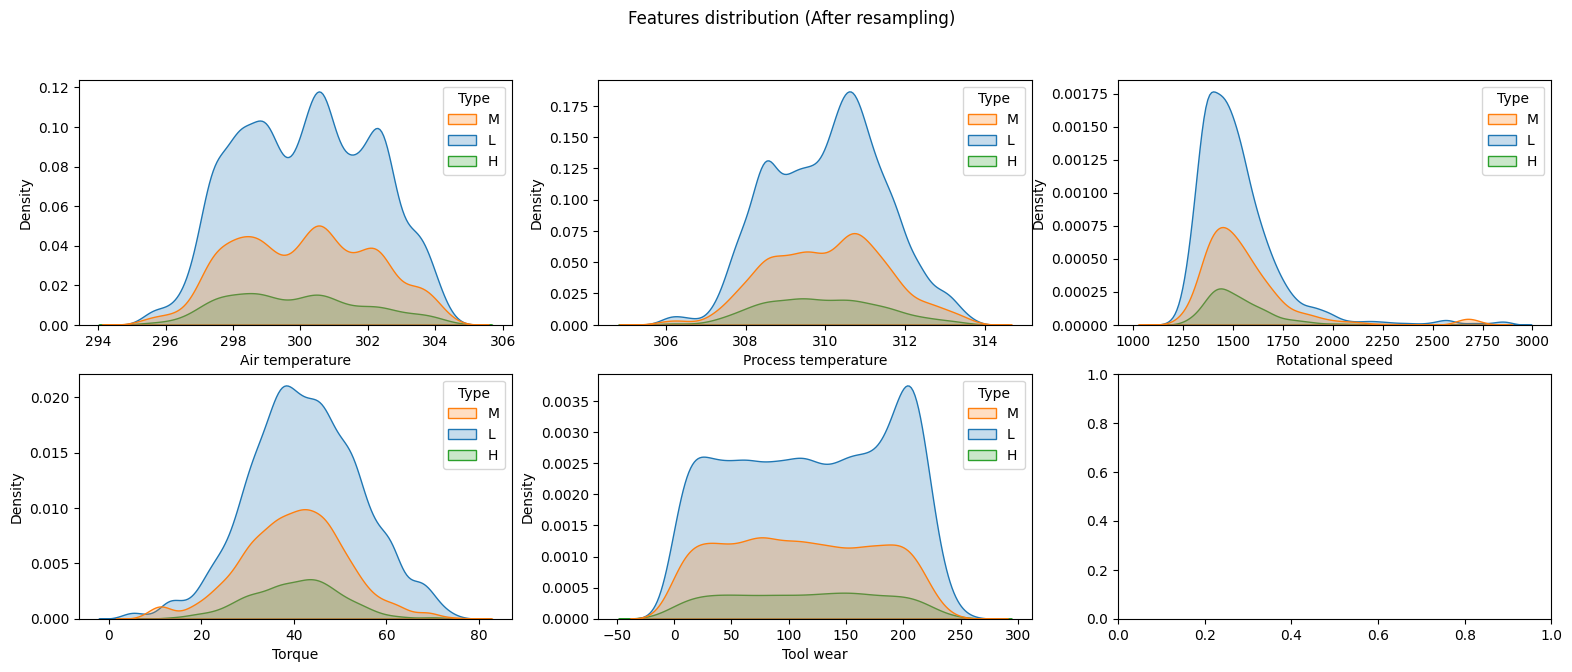

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(19,7))
fig.suptitle('Features distribution (After resampling)')
custom_palette = {'L':'tab:blue', 'M':'tab:orange', 'H':'tab:green'}
for j, feature in enumerate(num_features):
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
              hue='Type', fill=True, palette=custom_palette)
plt.show()

Finally, let’s look at how the distribution of features has changed.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

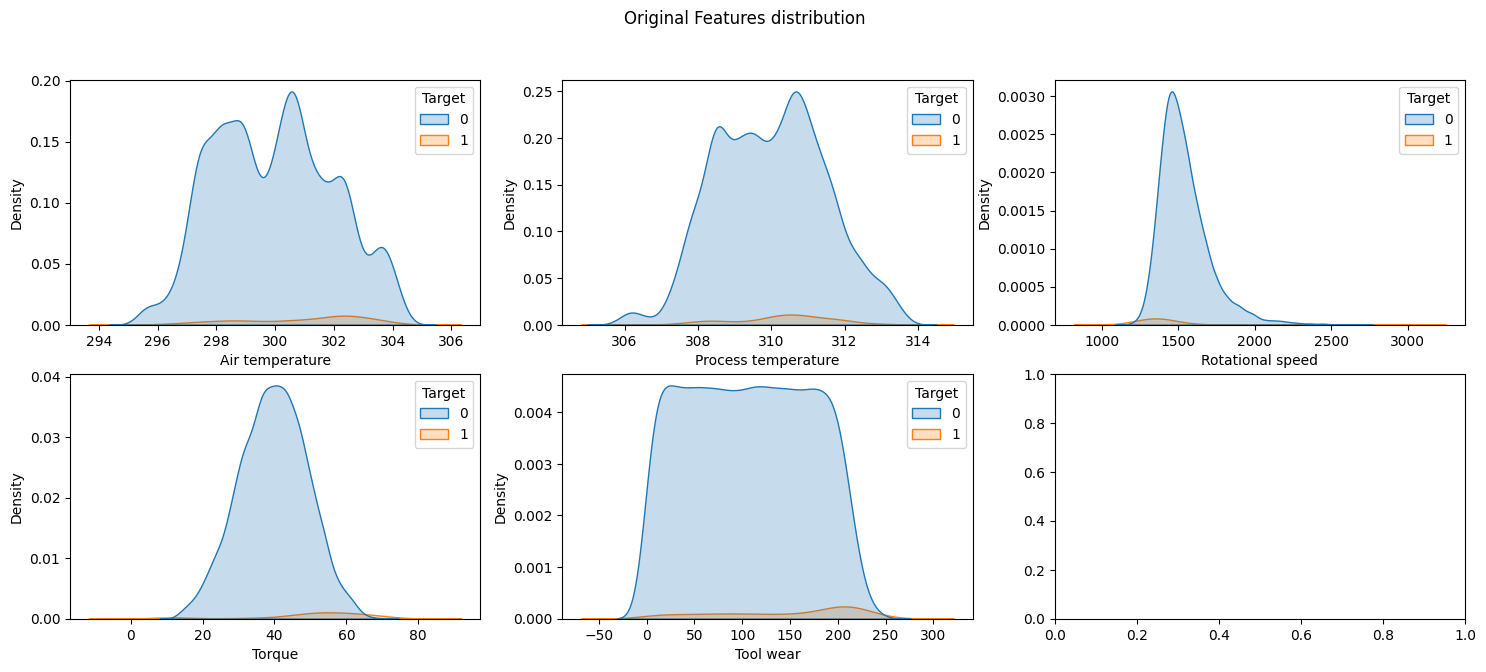

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

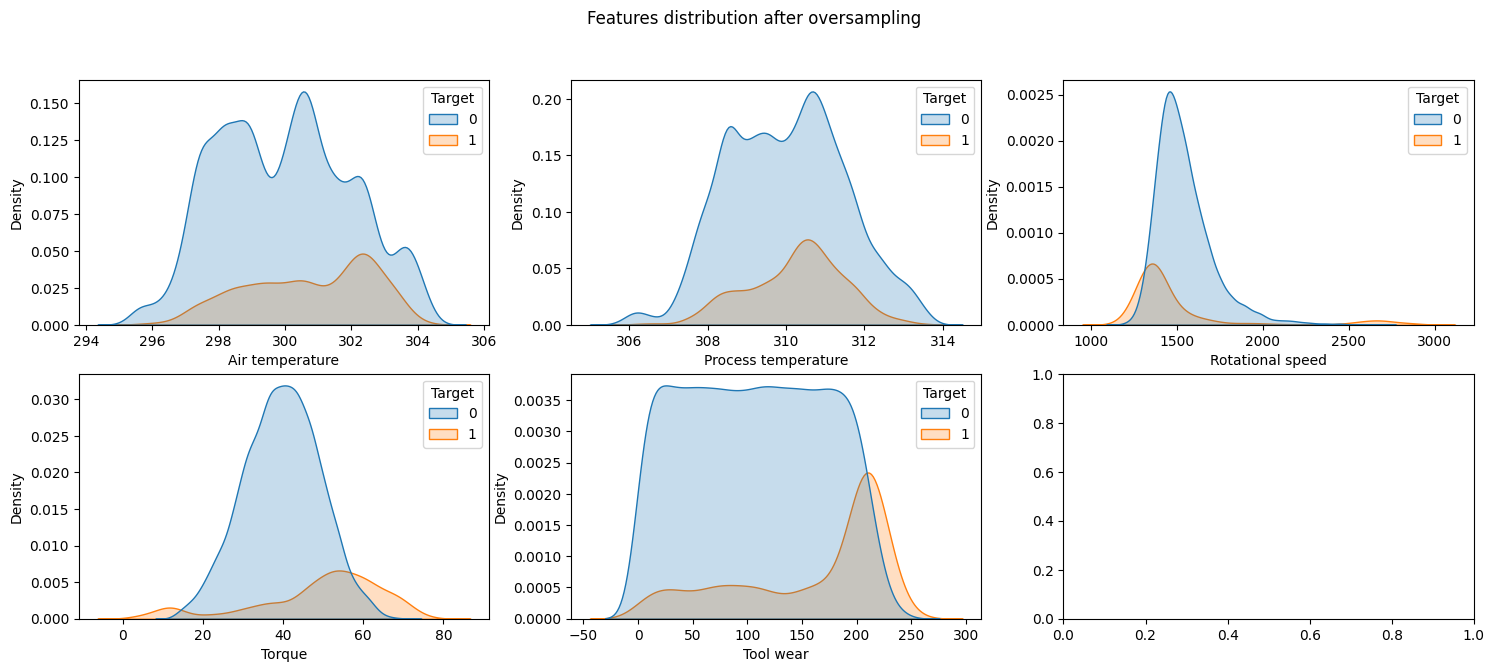

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

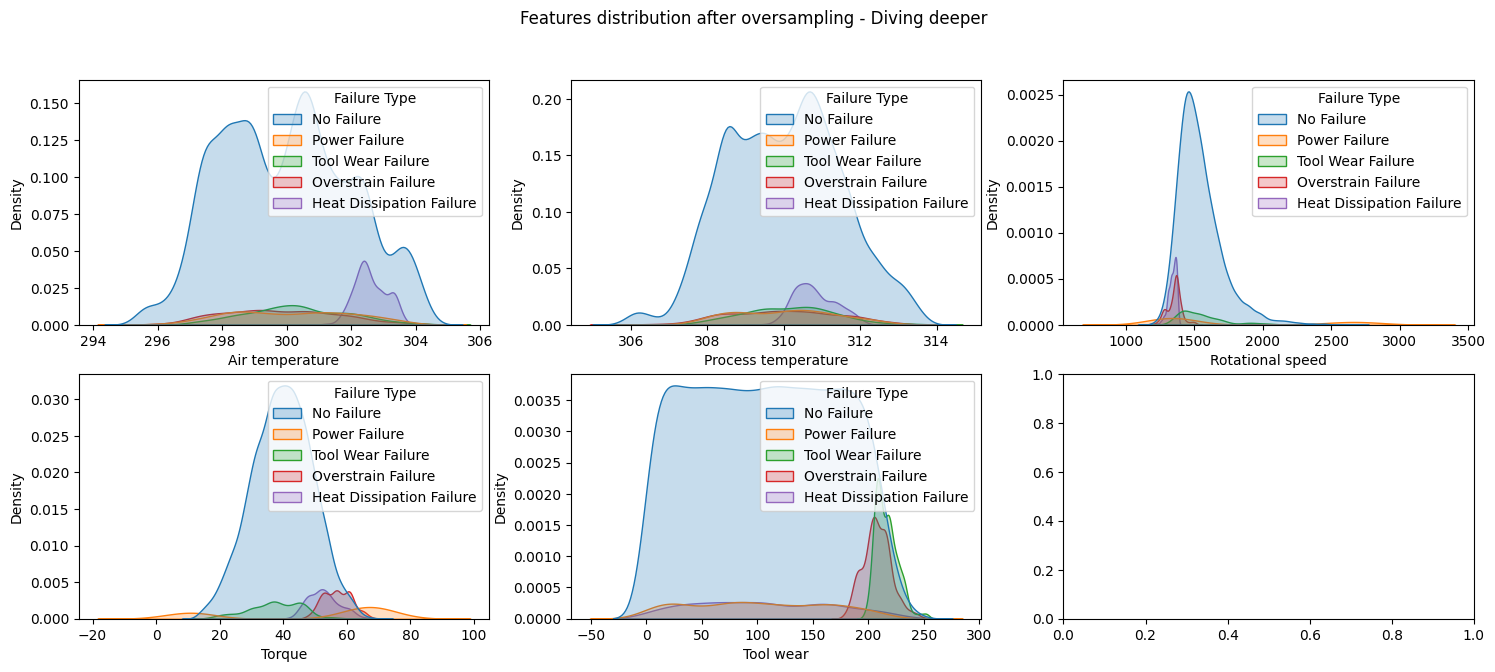

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Original Features distribution')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature,
                hue='Target', fill=True, palette='tab10')
plt.show()

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Features distribution after oversampling')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
                hue=df_res['Target'], fill=True, palette='tab10')
plt.show()

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Features distribution after oversampling - Diving deeper')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
                hue=df_res['Failure Type'], fill=True, palette='tab10')
plt.show()

###  Features scaling and Encoding <a id="encoding"></a>


In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}
df_pre = df_res.copy()
df_pre['Type'].replace(to_replace=type_dict, inplace=True)
df_pre['Failure Type'].replace(to_replace=cause_dict, inplace=True)
df_pre[num_features] = sc.fit_transform(df_pre[num_features]) 

/tmp/ipykernel_33/59320712.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pre['Type'].replace(to_replace=type_dict, inplace=True)
/tmp/ipykernel_33/59320712.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pre['Type'].replace(to_replace=type_dict, inplace=True)
/tmp/ipykernel_33/5932

### 2.7) PCA and Correlation Heatmap <a id="pca"></a>

We run PCA to have a further way of displaying the data instead of making feature selection.

In [45]:
pca = PCA(n_components=len(num_features))
X_pca = pd.DataFrame(data=pca.fit_transform(df_pre[num_features]), columns=['PC'+str(i+1) for i in range(len(num_features))])
var_exp = pd.Series(data=100*pca.explained_variance_ratio_, index=['PC'+str(i+1) for i in range(len(num_features))])
print('Explained variance ratio per component:', round(var_exp,2), sep='\n')
print('Explained variance ratio with 3 components: '+str(round(var_exp.values[:3].sum(),2)))

Explained variance ratio per component:
PC1    37.76
PC2    36.73
PC3    19.84
PC4     3.08
PC5     2.58
dtype: float64
Explained variance ratio with 3 components: 94.34


Since the first three components are enough to almost fully represent the variance of the data
we will project them in a three dimensional space.

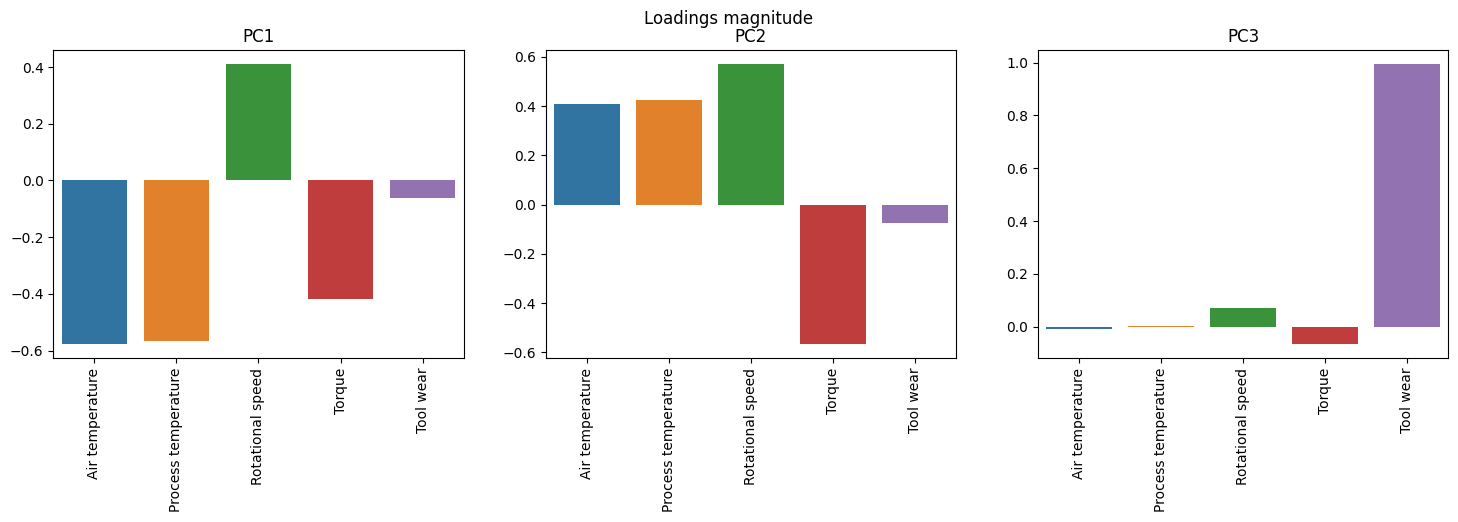

In [46]:
pca3 = PCA(n_components=3)
X_pca3 = pd.DataFrame(data=pca3.fit_transform(df_pre[num_features]), columns=['PC1','PC2','PC3'])

fig, axs = plt.subplots(ncols=3, figsize=(18,4))
fig.suptitle('Loadings magnitude')
pca_loadings = pd.DataFrame(data=pca3.components_, columns=num_features)
for j in range(3):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()  

The bar plot of Principal Components weights makes easy to understand what they represent:
* PC1 is closely related to the two temperature data;
* PC2 can be identified with the machine power, which is the product of Rotational Speed
and Torque;
* PC3 is identifiable with Tool Wear.

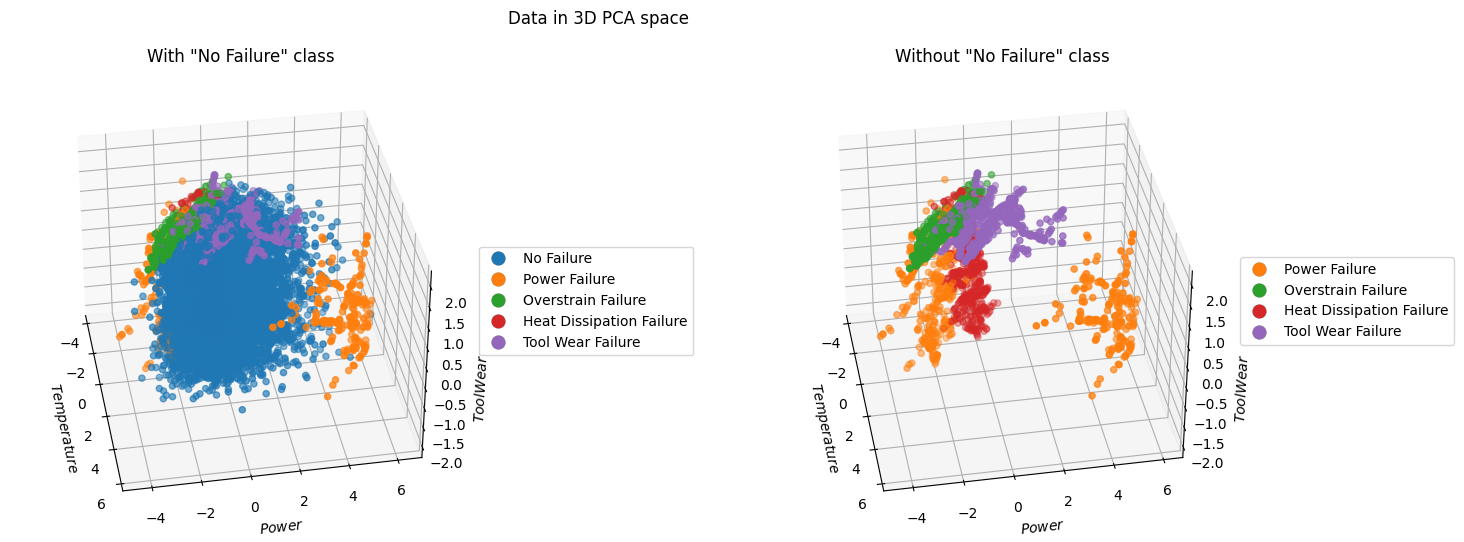

In [47]:
X_pca3.rename(mapper={'PC1':'Temperature',
                      'PC2':'Power',
                      'PC3':'Tool Wear'}, axis=1, inplace=True)

color = []
col = df_pre['Failure Type'].map({0:'tab:blue',1:'tab:orange',2:'tab:green',3:'tab:red',4:'tab:purple'})
color.append(col)
idx_w = col[col == 'tab:blue'].index
color.append(col.drop(idx_w))
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
labelTups = [('No Failure','tab:blue'),
             ('Power Failure', 'tab:orange'),
             ('Overstrain Failure','tab:green'),
             ('Heat Dissipation Failure', 'tab:red'),
             ('Tool Wear Failure','tab:purple')]

fig = plt.figure(figsize=(18,6))
fig.suptitle('Data in 3D PCA space')
full_idx = X_pca3.index

for j, idx in enumerate([full_idx,idx_fail_res]):
    ax = fig.add_subplot(1, 2, j+1, projection='3d')

    lg = ax.scatter(X_pca3.loc[idx,'Temperature'],
                    X_pca3.loc[idx,'Power'],
                    X_pca3.loc[idx,'Tool Wear'],
                    c=color[j])
    ax.set_xlabel('$Temperature$')
    ax.set_ylabel('$Power$')
    ax.set_zlabel('$Tool Wear$')
    ax.title.set_text('With'+str(j*'out')+' "No Failure" class')
    ax.view_init(35, -10) 
    custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                               mec='k', mfc=c, mew=.1, ms=20) for c in colors[j:]]
    ax.legend(custom_lines, [lt[0] for lt in labelTups[j:]], 
              loc='center left', bbox_to_anchor=(1.0, .5))
      
plt.show()

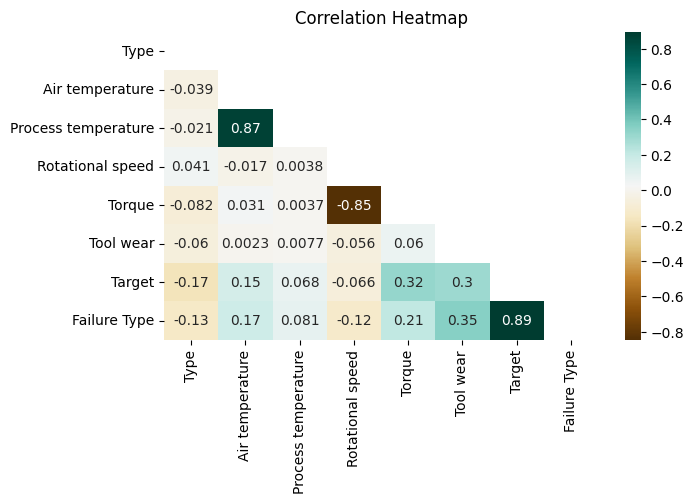

In [48]:
plt.figure(figsize=(7,4))
sns.heatmap(data=df_pre.corr(), mask=np.triu(df_pre.corr()), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap')
plt.show()


The goal of this section is to find the best model for binary classification of the dataset to predict whether or not there will be Machine Failure. 
At the beginning of a project a data scientist must make this division and the common ratios
used are:
* 70% train, 15% val, 15% test.
* 80% train, 10% val, 10% test.
* 60% train, 20% val, 20% test.


In [49]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import time

X, y = df_pre[features], df_pre[['Target','Failure Type']]
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=df_pre['Failure Type'], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, stratify=y_trainval['Failure Type'], random_state=0)

In [50]:
"""User-defined function: Evaluate cm, accurcay, AUC, F1 for a given classifier
- model, fitted estimator.
- X, data used to estimate class probabilities (paired with y_true)
- y_true, ground truth with two columns
- y_pred, predictions
- task = 'binary','multi_class'
"""
def eval_preds(model,X,y_true,y_pred,task):
    if task == 'binary':
        y_true = y_true['Target']
        cm = confusion_matrix(y_true, y_pred)

        proba = model.predict_proba(X)[:,1]

        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        f2 = fbeta_score(y_true, y_pred, pos_label=1, beta=2)
    elif task == 'multi_class':
        y_true = y_true['Failure Type']
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    metrics = pd.Series(data={'ACC':acc, 'AUC':auc, 'F1':f1, 'F2':f2})
    metrics = round(metrics,3)
    return cm, metrics

def tune_and_fit(clf,X,y,params,task):
    if task=='binary':
        f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                                cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Target'])
    elif task=='multi_class':
        f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                              cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Failure Type'])
        
    print('Best params:', grid_model.best_params_)

    train_time = time.time()-start_time
    mins = int(train_time//60)
    print('Training time: '+str(mins)+'m '+str(round(train_time-mins*60))+'s')
    return grid_model

def predict_and_evaluate(fitted_models,X,y_true,clf_str,task):
    cm_dict = {key: np.nan for key in clf_str}
    metrics = pd.DataFrame(columns=clf_str)
    y_pred = pd.DataFrame(columns=clf_str)
    for fit_model, model_name in zip(fitted_models,clf_str):

        y_pred[model_name] = fit_model.predict(X)

        if task == 'binary':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        elif task == 'multi_class':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)

        cm_dict[model_name] = cm
        metrics[model_name] = scores
    return y_pred, cm_dict, metrics

def fit_models(clf,clf_str,X_train,X_val,y_train,y_val):
    metrics = pd.DataFrame(columns=clf_str)
    for model, model_name in zip(clf, clf_str):
        model.fit(X_train,y_train['Target'])
        y_val_pred = model.predict(X_val)
        metrics[model_name] = eval_preds(model,X_val,y_val,y_val_pred,'binary')[1]
    return metrics

### Feature selection attempts <a id="selection"></a>


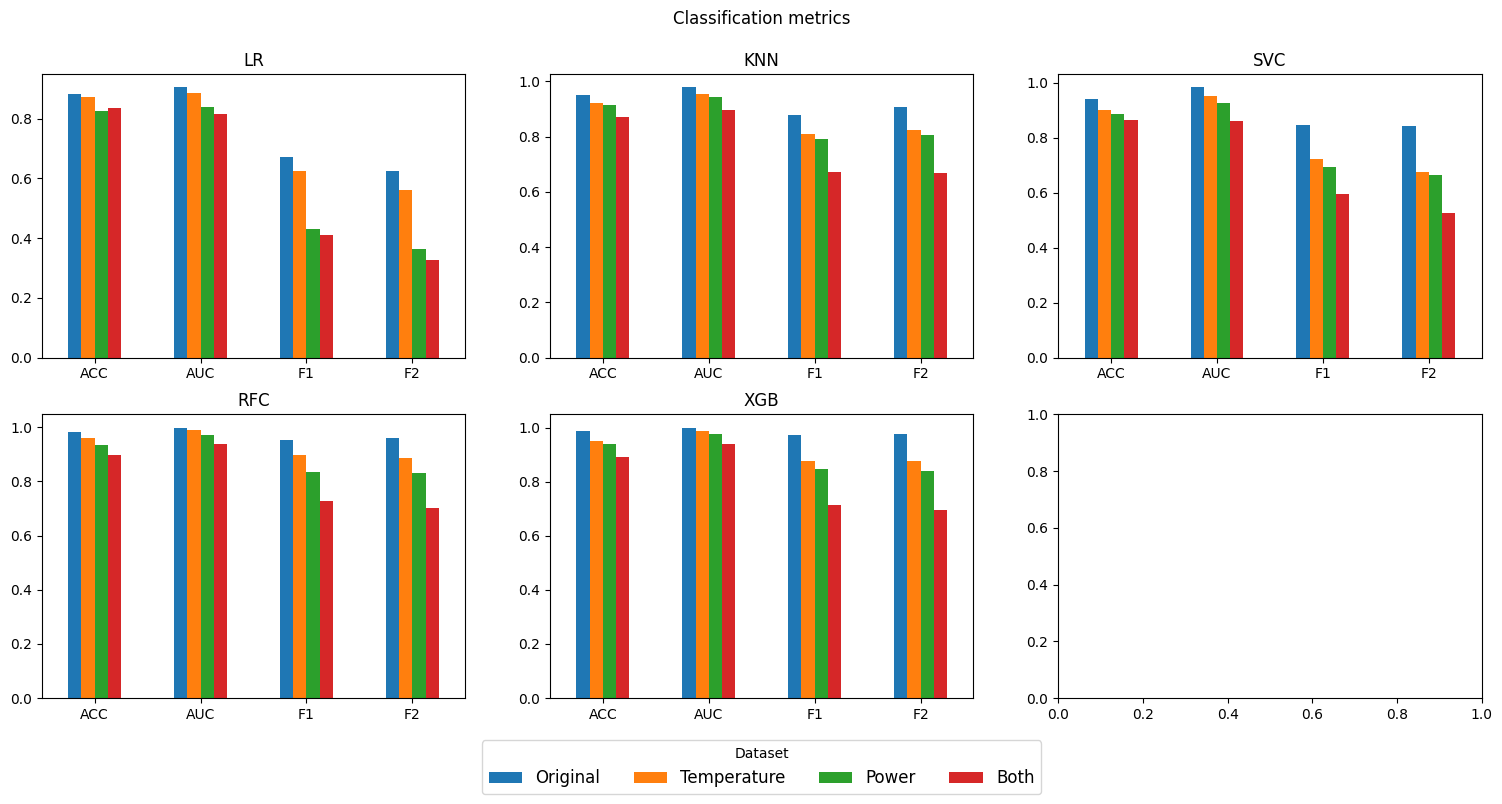

In [51]:
lr = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC(probability=True)
rfc = RandomForestClassifier()
xgb = XGBClassifier() 

clf = [lr,knn,svc,rfc,xgb]
clf_str = ['LR','KNN','SVC','RFC','XGB'] 

metrics_0 = fit_models(clf,clf_str,X_train,X_val,y_train,y_val)

XX_train = X_train.drop(columns=['Process temperature','Air temperature'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature'] = X_val['Process temperature']*X_val['Air temperature']
metrics_1 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

XX_train = X_train.drop(columns=['Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Rotational speed','Torque'])
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']     
metrics_2 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

XX_train = X_train.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature']= X_val['Process temperature']*X_val['Air temperature']
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']       
metrics_3 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8))
fig.suptitle('Classification metrics')
for j, model in enumerate(clf_str):
    ax = axs[j//3,j-3*(j//3)]
    model_metrics = pd.DataFrame(data=[metrics_0[model],metrics_1[model],metrics_2[model],metrics_3[model]])
    model_metrics.index = ['Original','Temperature','Power','Both']
    model_metrics.transpose().plot(ax=ax, kind='bar', rot=0, )
    ax.title.set_text(model)
    ax.get_legend().remove()
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
axs.flatten()[-2].legend(title='Dataset', loc='upper center',
                         bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=12)
plt.show()

From the results obtained, we observe that all the models applied to the entire dataset perform
better than when they are applied to the ones created by reducing the number of features.
The best performances and the modest number of features from which our dataset is composed
encourage us to opt to avoid the feature selection step.


We decide to use Logistic Regression as a Benchmark for our task. It
represents an intermediate step between the basic model referred to in Section 2.4 and the more
complex models that we have described and we will explore in depth in the following sections.
Now we look at the results obtained and at the interpretability of the model.

Validation set metrics:
ACC    0.882
AUC    0.904
F1     0.670
F2     0.625
dtype: float64
Test set metrics:
ACC    0.883
AUC    0.917
F1     0.662
F2     0.605
dtype: float64


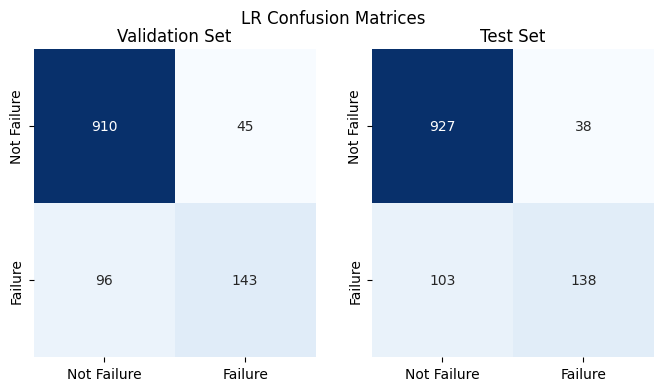

,feature,odds
4,Torque,16.813695
3,Rotational speed,9.436690
1,Air temperature,4.470158
5,Tool wear,3.481360
0,Type,0.524321
2,Process temperature,0.348702


In [52]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train['Target'])
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'binary')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'binary')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

cm_labels = ['Not Failure', 'Failure']
cm_lr = [cm_val_lr, cm_test_lr]

fig, axs = plt.subplots(ncols=2, figsize=(8,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Blues', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()

d = {'feature': X_train.columns, 'odds': np.exp(lr.coef_[0])}
odds_df = pd.DataFrame(data=d).sort_values(by='odds', ascending=False)
odds_df

In [53]:
knn = KNeighborsClassifier()
svc = SVC()
rfc = RandomForestClassifier()
xgb = XGBClassifier() 
clf = [knn,svc,rfc,xgb]
clf_str = ['KNN','SVC','RFC','XGB']

knn_params = {'n_neighbors':[1,3,5,8,10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}
xgb_params = {'n_estimators':[300,500,700],
              'max_depth':[5,7],
              'learning_rate':[0.01,0.1],
              'objective':['binary:logistic']}
params = pd.Series(data=[knn_params,svc_params,rfc_params,xgb_params],
                   index=clf)

print('GridSearch start')
fitted_models_binary = []
for model, model_name in zip(clf, clf_str):
    print('Training '+str(model_name))
    fit_model = tune_and_fit(model,X_train,y_train,params[model],'binary')
    fitted_models_binary.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 3}
Training time: 0m 4s
Training SVC
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 1m 38s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 700, 'random_state': 0}
Training time: 3m 40s
Training XGB
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'objective': 'binary:logistic'}
Training time: 0m 38s


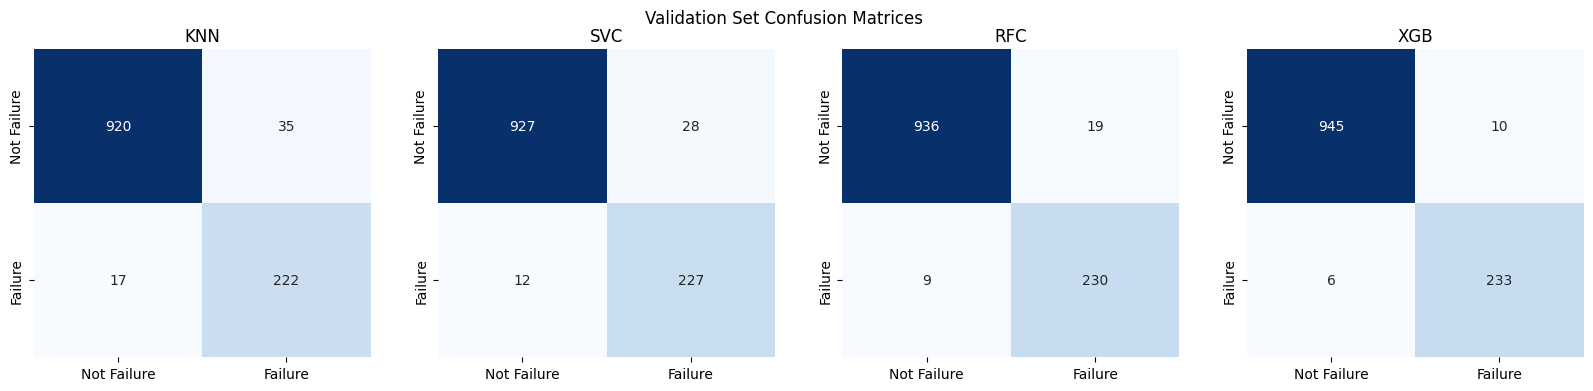

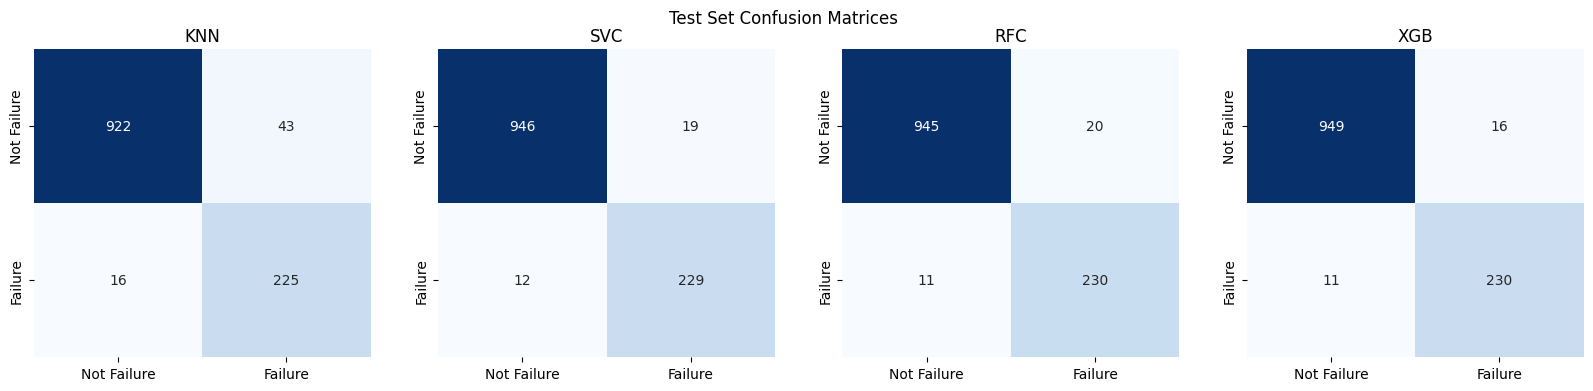


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.956  0.966  0.977  0.987
AUC  0.975  0.986  0.997  0.999
F1   0.895  0.919  0.943  0.967
F2   0.915  0.937  0.954  0.972
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.951  0.974  0.974  0.978
AUC  0.979  0.992  0.996  0.998
F1   0.884  0.937  0.937  0.945
F2   0.913  0.945  0.947  0.950


In [54]:
task = 'binary'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_binary,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_binary,X_test,y_test,clf_str,task)

fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

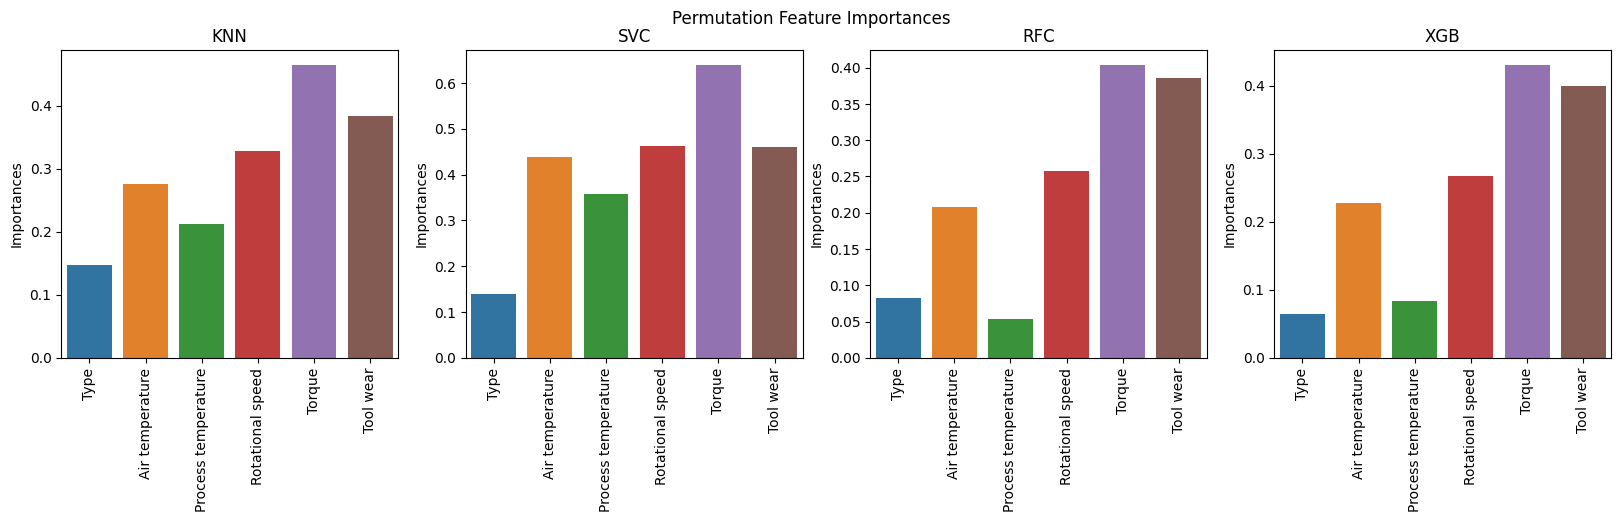

In [55]:
f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
importances = pd.DataFrame()
for clf in fitted_models_binary:
    result = permutation_importance(clf, X_train,y_train['Target'],
                                  scoring=f2_scorer,random_state=0)
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    importances = pd.concat(objs=[importances,result_mean],axis=1)
importances.columns = clf_str

fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[name].values)
    axs[j].tick_params('x',labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].title.set_text(str(name))
plt.show()

Validation set metrics:
ACC    0.925
AUC    0.983
F1     0.908
F2     0.917
dtype: float64
Test set metrics:
ACC    0.922
AUC    0.983
F1     0.904
F2     0.914
dtype: float64


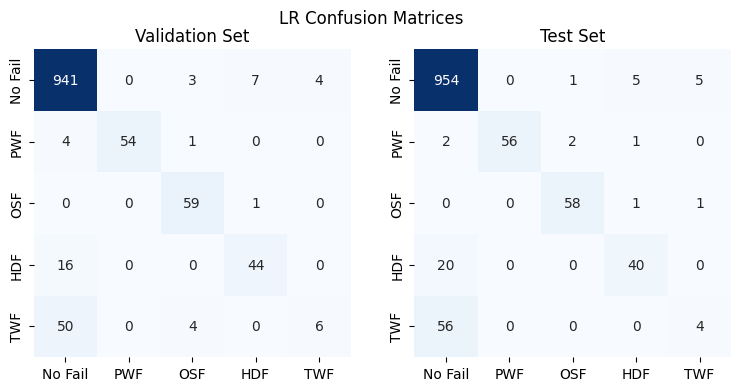

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
No Failure,1.907229,0.223706,2.867778,0.105969,0.059475,0.287244
Power Failure,0.677131,0.863747,0.951600,935.510554,2819.835159,0.736494
Tool Wear Failure,0.045739,0.222402,2.772545,0.109064,8.363593,378.888240
Overstrain Failure,0.651006,4260.644951,0.004292,0.000450,0.390559,0.710884
Heat Dissipation Failure,1.046280,1.342552,0.737372,0.224577,0.117967,750.853657


In [56]:
lr = LogisticRegression(random_state=0,multi_class='ovr')
lr.fit(X_train, y_train['Failure Type'])
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'multi_class')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'multi_class')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

cm_lr = [cm_val_lr, cm_test_lr]
cm_labels = ['No Fail','PWF','OSF','HDF','TWF']

fig, axs = plt.subplots(ncols=2, figsize=(9,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Blues', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()

odds_df = pd.DataFrame(data = np.exp(lr.coef_), columns = X_train.columns,
                       index = df_res['Failure Type'].unique())
odds_df

In the table above there are, for every class, the Logistic Regression’s odds that
explain the contribution of each feature in the prediction of belonging to a specific class. By
comparing this table with the PCA scatter and the comments we made, we understand that there
is a complete agreement about the features that most affect the type of failure. For example, if
we look at odds’ values of PWF, we see that Rotational Speed and Torque are the ones that are
most important for the forecast of belonging to this class. In the analysis of the PCA we stated
that PWF seems to be dependent only on PC2, i.e. the Power that is the product of Rotational
Speed and Torque. We can make similar considerations for other classes.

In [57]:
knn = KNeighborsClassifier()
svc = SVC(decision_function_shape='ovr')
rfc = RandomForestClassifier()
xgb = XGBClassifier()
clf = [knn,svc,rfc,xgb]
clf_str = ['KNN','SVC','RFC','XGB']

knn_params = {'n_neighbors':[1,3,5,8,10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}
xgb_params = {'n_estimators':[100,300,500],
              'max_depth':[5,7,10],
              'learning_rate':[0.01,0.1],
              'objective':['multi:softprob']}

params = pd.Series(data=[knn_params,svc_params,rfc_params,xgb_params],
                    index=clf)

print('GridSearch start')
fitted_models_multi = []
for model, model_name in zip(clf, clf_str):
    print('Training '+str(model_name))
    fit_model = tune_and_fit(model,X_train,y_train,params[model],'multi_class')
    fitted_models_multi.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 1}
Training time: 0m 4s
Training SVC
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 1m 50s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 700, 'random_state': 0}
Training time: 3m 45s
Training XGB
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'objective': 'multi:softprob'}
Training time: 2m 25s


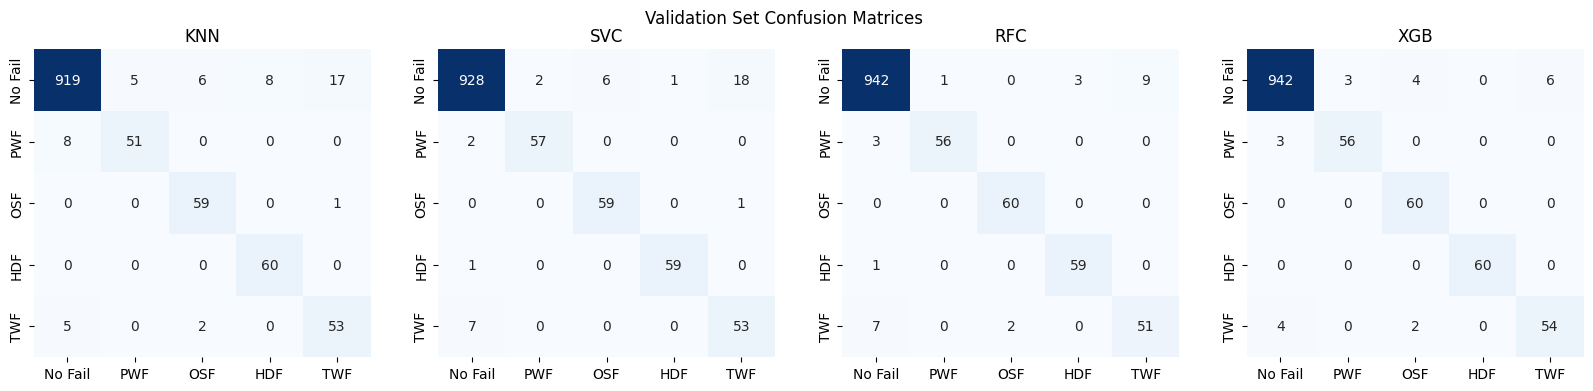

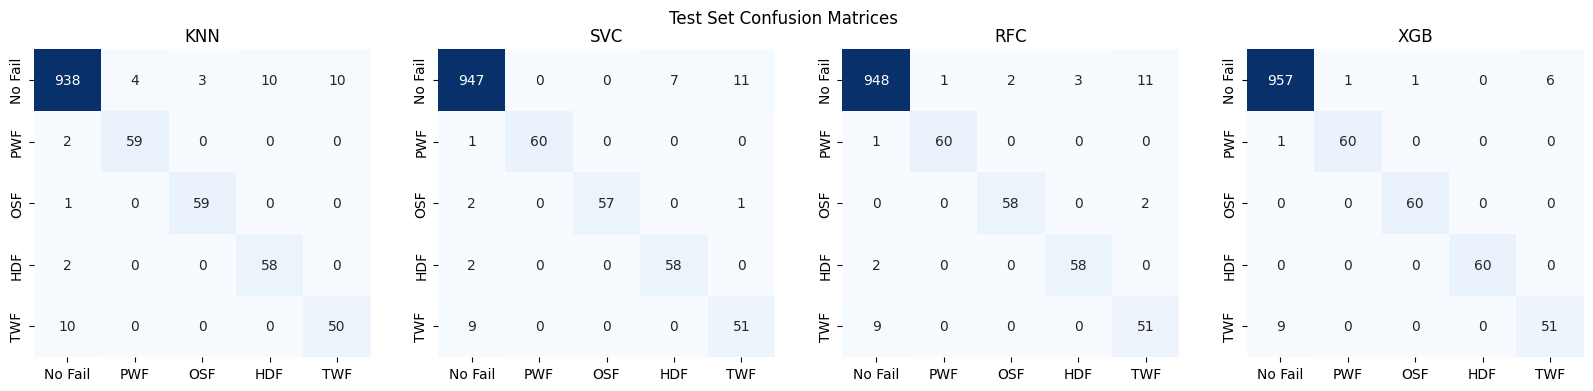


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.956  0.968  0.978  0.982
AUC  0.956  0.993  0.998  0.999
F1   0.957  0.969  0.978  0.982
F2   0.957  0.968  0.978  0.982
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.965  0.973  0.974  0.985
AUC  0.957  0.995  0.997  0.999
F1   0.965  0.973  0.975  0.985
F2   0.965  0.973  0.974  0.985


In [58]:
task = 'multi_class'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_multi,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_multi,X_test,y_test,clf_str,task)

fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

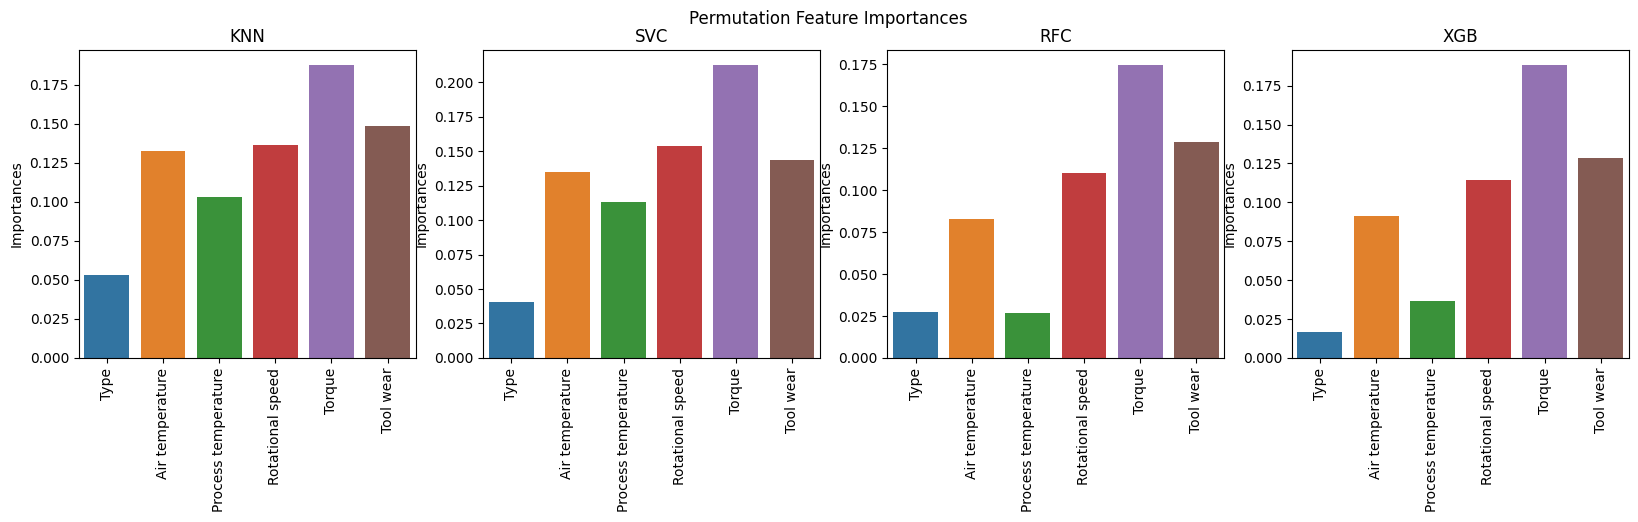

In [59]:
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
importances = pd.DataFrame()
for clf in fitted_models_multi:
    result = permutation_importance(clf, X_train,y_train['Failure Type'],
                                  scoring=f2_scorer,random_state=0)
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    importances = pd.concat(objs=[importances,result_mean],axis=1)

importances.columns = clf_str

fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[name].values)
    axs[j].tick_params('x',labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].title.set_text(str(name))
plt.show()

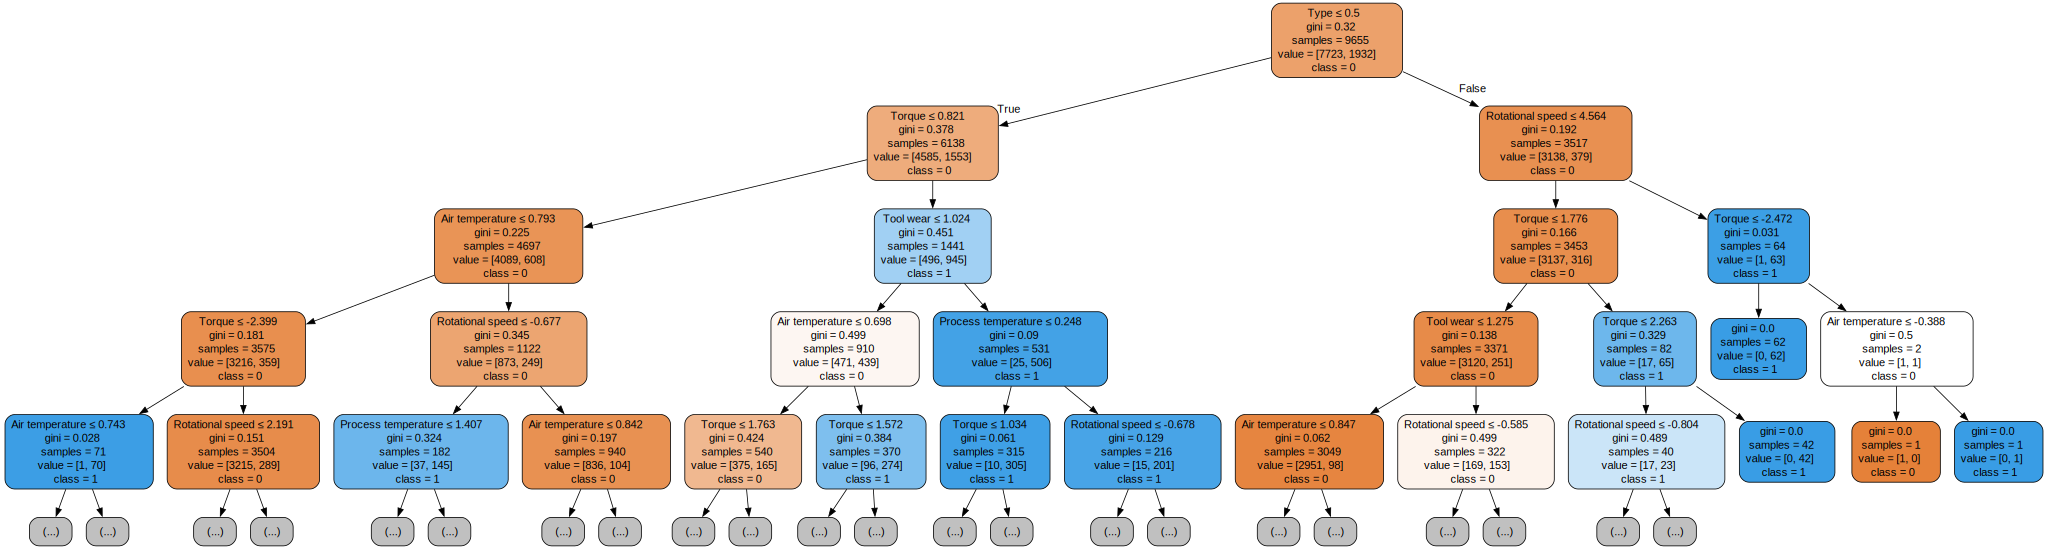

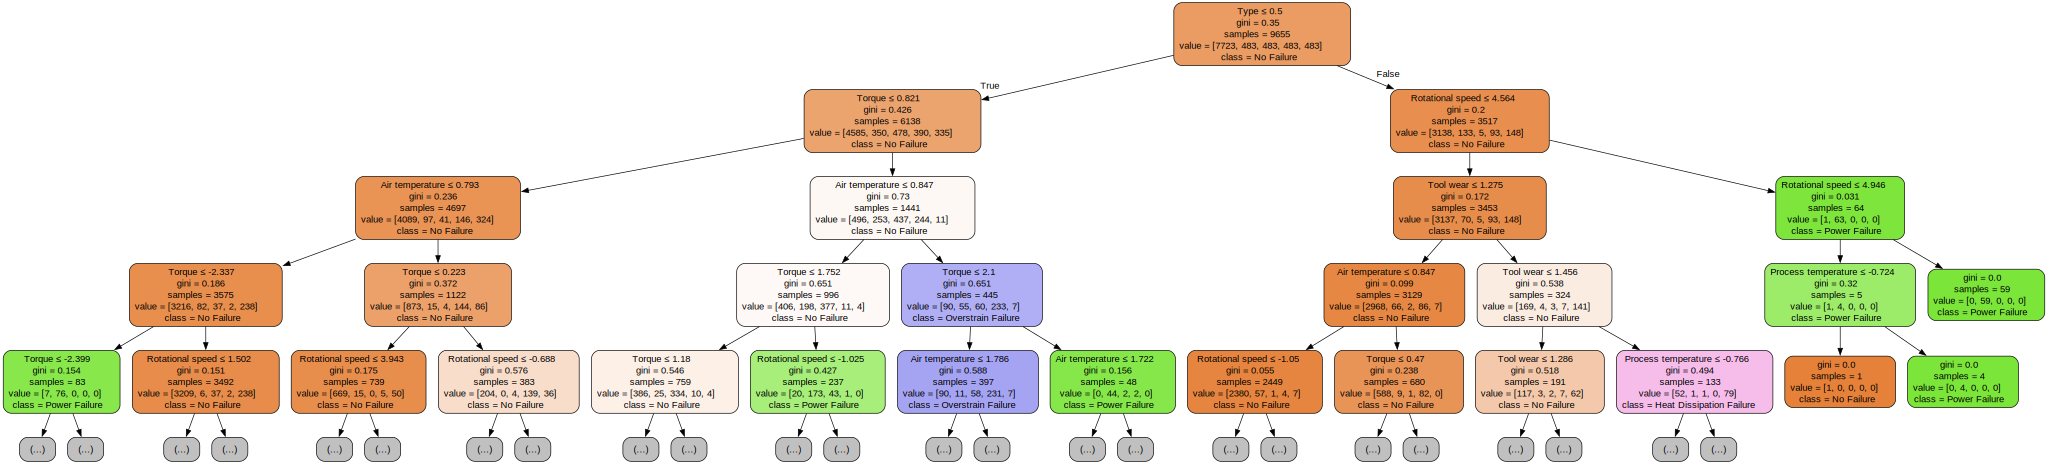

In [60]:
from sklearn import tree
import graphviz

tree_binary = fitted_models_binary[2].best_estimator_.estimators_[0]
tree_multi = fitted_models_multi[2].best_estimator_.estimators_[0]
trees = [tree_binary,tree_multi]
targets = ['Target', 'Failure Type']
for decision_tree, target in zip(trees, targets):
    decision_tree.fit(X_train,y_train[target])
    classes = list(map(str,df_res[target].unique()))

    dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                                  feature_names=X.columns,  
                                  class_names=classes,
                                  filled=True, rounded=True,  
                                  special_characters=True,
                                  max_depth=4) 
    graph = graphviz.Source(dot_data)
    graph.render(target+" Classification tree")
    display(graph)

## **Conclusions** <a id="conclusions"></a>

According to the analyses carried out and the results obtained, it is possible to make some
conclusive considerations related to this project.

At the end, we can conclude that for both task the chosen models perform very well. For both
tasks the best model is XGBoost and the worst is KNN; however the response time of KNN
is instant while XGBoost takes more time and this further increase when we proceed with the
multi-class classification task. The choice of the model depends on the needs of the company: for
faster application one can use KNN while if one cares more about accuracy one can use XGBoost.